In [1]:
# code from https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import string
import warnings 
import re
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

## 1 加载数据

In [3]:
def concat_df(train_data,test_data):
    return pd.concat([train_data,test_data]).reset_index(drop=True)

def divide_df(all_data):
    return all_data.loc[:890],all_data.loc[891:].drop(['Survived'],axis = 1)
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
df_all   = concat_df(df_train,df_test)
dfs      = [df_train,df_test]
df_train.shape,df_test.shape,df_all.shape

((891, 12), (418, 11), (1309, 12))

## 2 数据的挖掘

### 2.1 数据缺失值 -训练数据缺失 Age/Cabin/Embarked

In [4]:
#df_train.info()

### 2.2 测试数据缺失值: Age/Fare/Cabin/

In [5]:
#df_test.info()

### 2.3 先处理Age缺少的数据

In [6]:
# 先确定Age更哪些因数相关，再确定按照什么规则填写；下面的数据分析显示Age跟Pclass有很大的相关性
# 而且为了更加准确，我们填充Age的时候也考虑性别sex 这个因数；所以下面会按照Sex and Pclass分组，然后
# 对于哪个分组缺失的值由哪个分组的值来填充

In [7]:
# 这一步是计算所有元素之间的相关，然后做成表格的形式
df_all_corr = df_all.corr().abs().unstack().sort_values(ascending= False).reset_index() 
# 下面这个是对表格的题目做一下rename 
df_all_corr.rename(columns={'level_0':'Feature1','level_1':'Feature2',0:'Corr_Coeff'},inplace  = True)
df_all_corr[df_all_corr['Feature1'] == 'Age']

,Feature1,Feature2,Corr_Coeff
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [8]:
### 对数据分组后,对于各个分组缺失的数据，由各个分组的median值来填充
df_all.groupby(['Sex','Pclass']).median()['Age']

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [9]:
## 填充
df_all['Age'] = df_all.groupby(['Sex','Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
#df_all['Age'].isnull().sum()

### 2.4 再处理缺失Embarked 数据

In [10]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [11]:
## 抽取出船票号并转成数字，方便后边执行 = [(df_all['Ticket']>=110152)&(df_all['Ticket']<=113798)]
#df_all.groupby(['Sex','Pclass','Parch','SibSp','Ticket'])['Embarked'].value_counts()
df_all['Ticket_Nums'] = df_all['Ticket'].map(lambda x:re.sub('\D','',x))
df_all['Ticket_Nums'] = pd.to_numeric(df_all['Ticket_Nums'])
select_data = df_all[(df_all['Sex'] == 'female')&(df_all['SibSp'] == 0)&(df_all['Parch'] == 0)&(df_all['Pclass'] ==1)]
data_sel    = select_data[(df_all['Ticket_Nums']>=110152)&(df_all['Ticket_Nums']<=113798)]
data_sel['Embarked'].value_counts()

S    8
C    3
Name: Embarked, dtype: int64

In [12]:
###从上面的结果可以看出  - S占有的数量占多数，所以填充缺失的embarked值用‘S’
df_all = df_all.drop('Ticket_Nums',axis = 1)
df_all['Embarked']= df_all['Embarked'].fillna("S")
#df_all['Embarked'].isnull().sum()

### 2.5 再处理缺失Fare数据  - 票的价钱

In [13]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [14]:
Fare_value = df_all[(df_all['Embarked'] == 'S')&(df_all['Parch'] == 0) &
       (df_all['Pclass'] == 3) & (df_all['Sex'] == 'male') & (df_all['SibSp'] == 0)]['Fare'].median() # 中位数
df_all['Fare'] = df_all['Fare'].fillna(Fare_value)

### 2.6 抽取座舱Cabin的首字母来做成一个新的特征

In [15]:
df_all['Deck'] = df_all['Cabin'].apply(lambda x:x[0] if pd.notnull(x) else 'M')
#df_all['Deck'].unique()
#array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [16]:
### 统计了每个座舱的幸存率发现 ABC都是Pclass=1;
# DE`是Pclass=1占多数，Pclass=2占少数
# FG 是pclass=3占多数，pclass=2占少数
# T都是Pclass=1; Deck = T的转成A类

In [20]:
## 将分组归类一下
T_index = df_all[df_all['Deck'] == 'T'].index
df_all.loc[T_index,'Deck'] = 'A'
df_all['Deck'] = df_all['Deck'].replace(['A','B','C'],'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D','E'],'DE')
df_all['Deck'] = df_all['Deck'].replace(['F','G'],'FG')

#df_all['Deck'].value_counts()

### 2.7 幸存率和死亡率

In [21]:
survived_1 = df_all[df_all['Survived'] == 1]['Survived'].value_counts()#df_all['Survived'].value_counts()[0]
survived_0 = df_all[df_all['Survived'] == 0]['Survived'].value_counts()
print("幸存率是{:0.2f}%,  死亡率是{:0.2f}%".format(100*survived_1[1]/df_train.shape[0],100*survived_0[0]/df_train.shape[0]))

幸存率是38.38%,  死亡率是61.62%


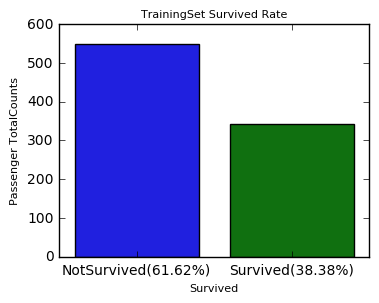

In [22]:
plt.figure(figsize = (4,3))
sns.countplot(df_train['Survived'])
plt.xlabel('Survived',size=8)
plt.ylabel('Passenger TotalCounts',size=8)
plt.title('TrainingSet Survived Rate',size =8)
survived_rate = 100*survived_1[1]/df_train.shape[0]
notsurvived_rate = 100*survived_0[0]/df_train.shape[0]
plt.xticks((1,0),['Survived({0:.2f}%)'.format(survived_rate),'NotSurvived({0:.2f}%)'.format(notsurvived_rate)])
plt.tick_params(axis = 'x')
plt.show()

### 2.8 相关的计算

In [25]:
df_trian_corr = df_train.drop('PassengerId',axis=1).corr().abs().unstack().sort_values(ascending= False).reset_index()
df_test_corr  = df_test.drop('PassengerId',axis=1).corr().abs().unstack().sort_values(ascending= False).reset_index()

df_trian_corr = df_trian_corr.rename(columns={'level_0':'Featrue1','level_1':'Feature2',0:'Corr_coeff'},inplace=True)
#df_trian_corr[df_trian_corr['Corr_coeff']>0.1]

In [27]:
## 结论: 大部分的样本都是彼此相关的，这些相关可以用来创建新的特征；目标编码traget encoding可以非常有用，因为他们跟
#  survived 是相关的
# 离散的种类特征跟幸存率也有相关，这些特征可以通过one=hot编码来表示。创建了一个新的特征-去掉了Cabin的特征
#df_all=df_all.drop('Cabin',axis=1)
df_all.head(2)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC


## 3 特征工程 - 连续特征的处理 - Age and Fare

### 3.1 将Fare特征切割成13分段 - 每个分段的样本数据都有自己的生成率和死亡率

In [28]:
df_all['Fare'] = pd.qcut(df_all['Fare'],13)

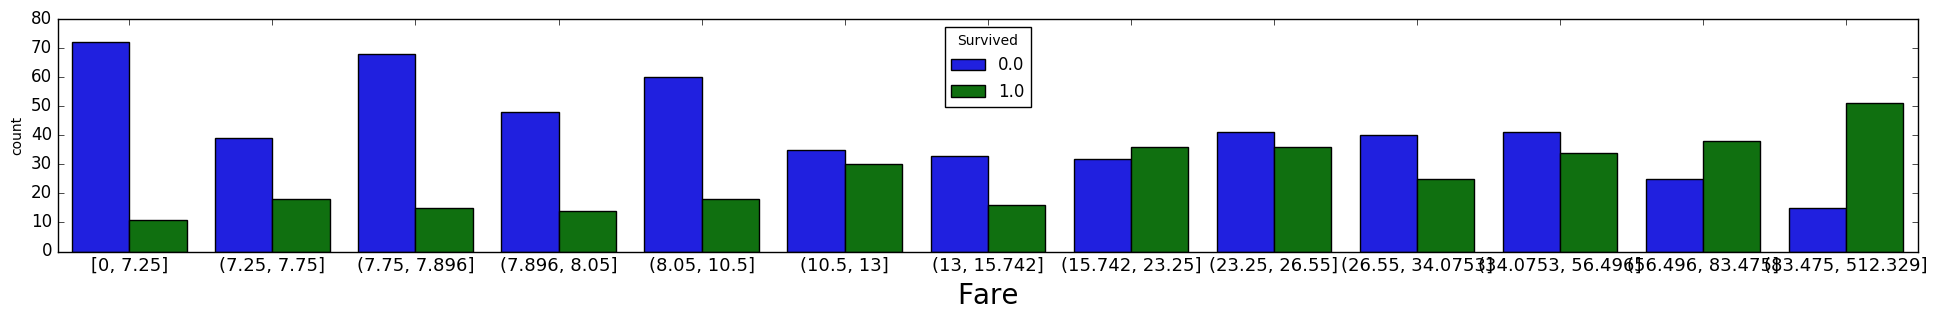

In [29]:
### 下面的代码可以通过图像看一看
plt.figure(figsize = (24,3))
sns.countplot(x = 'Fare',hue = "Survived",data = df_all)
plt.xlabel('Fare',size =20)
plt.tick_params(axis = 'x',labelsize=13) # x轴刻度的大小
plt.tick_params(axis = 'y',labelsize=12) # y轴刻度的大小
plt.show()

### 3.2 将Age特征切割成10分段 - 每个分段的样本数据都有自己的生成率和死亡率

In [30]:
df_all["Age"] = pd.qcut(df_all["Age"],10)

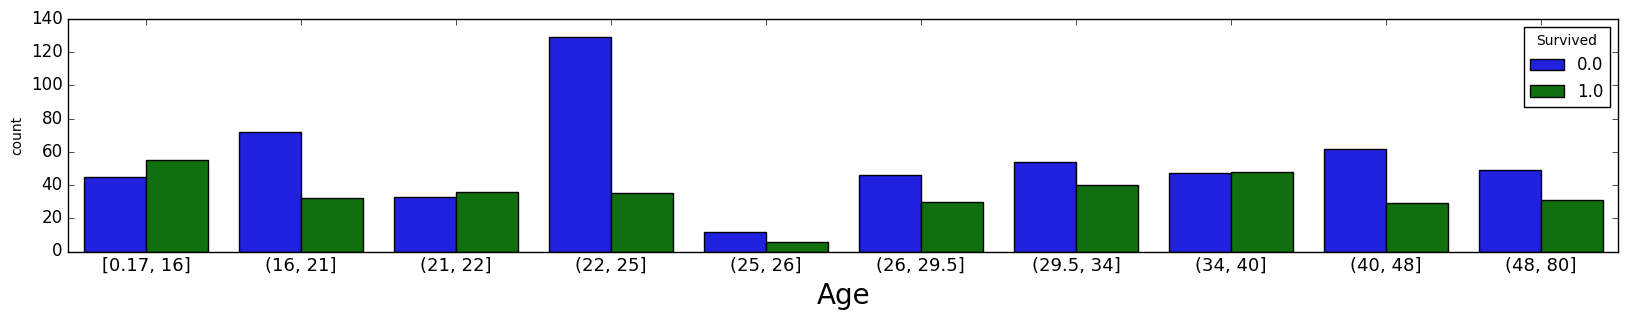

In [31]:
### 下面的代码可以通过图像看一看
plt.figure(figsize = (20,3))
sns.countplot(x = 'Age',hue = "Survived",data = df_all)
plt.xlabel('Age',size =20)
plt.tick_params(axis = 'x',labelsize=13) # x轴刻度的大小
plt.tick_params(axis = 'y',labelsize=12) # y轴刻度的大小
plt.show()

### 3.3 引入新的特征: Family_Size and Ticket_Frequency

In [32]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

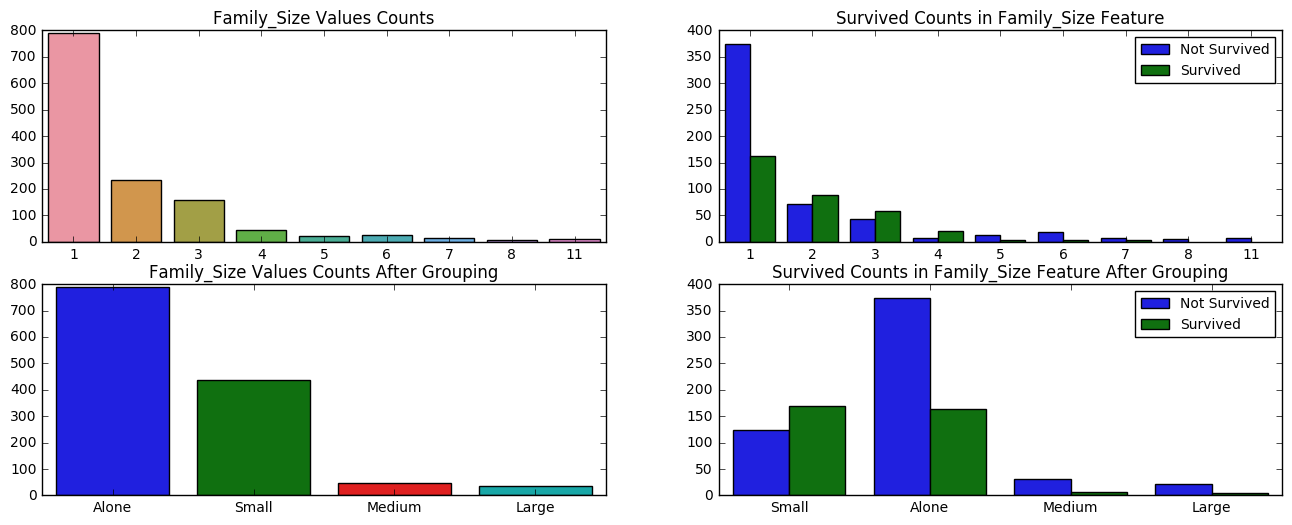

In [33]:
### 下面分别图像显示每个分类的总数及每个分类的幸存率和死亡率比例
fig,axs = plt.subplots(figsize = (16,6),ncols =2,nrows=2)
sns.barplot(x = df_all['Family_Size'].value_counts().index,y = df_all['Family_Size'].value_counts().values,ax =
            axs[0][0])

axs[0][0].set_title("Family_Size Values Counts",size =12)

sns.countplot(x = 'Family_Size',hue = 'Survived',data =df_all,ax = axs[0][1])
axs[0][1].set_title("Survived Counts in Family_Size Feature",size =12)


##-------------- 第2行的图像------------
# 将Family_Size 按照大小进行分类，分成Alone,Small,Medium,Large - 4 个分类
family_map = {1:'Alone',2:'Small',3:'Small',4:'Small',5:'Medium',6:'Medium',7:'Large',8:'Large',11:'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)
sns.barplot(x = df_all['Family_Size_Grouped'].value_counts().index,
           y = df_all['Family_Size_Grouped'].value_counts().values,ax = axs[1][0])
axs[1][0].set_title("Family_Size Values Counts After Grouping",size =12)

sns.countplot(x = 'Family_Size_Grouped',hue = 'Survived',data = df_all,ax = axs[1][1])
axs[1][1].set_title("Survived Counts in Family_Size Feature After Grouping",size =12)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 10})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=10)
        axs[i][j].tick_params(axis='y', labelsize=10)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

In [34]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

### 3.4 引入新的特征: Title and Ismarried 

In [35]:
df_all['Title'] = df_all['Name'].str.split(",",expand = True)[1].str.split('.',expand = True)[0]

In [36]:
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1 

In [37]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

In [54]:
df_all['Title']

KeyError: 'Title'

### 3.5 引入新的特征: Family

In [38]:
def extract_surname(data):
    families = []
    for i in range(len(data)):
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name 
        family = name_no_bracket.split(',')[0]
        title  = name_no_bracket.split(',')[1].strip().split(' ')[0]
        for c in string.punctuation:
            family = family.replace(c,'').strip()
        families.append(family)
    return families

In [39]:
df_all['Family'] = extract_surname(df_all['Name'])

### 3.6 重新切分数据 - 并引入新的特征 Family_survived_rate/Ticket_survived_rate

In [40]:
df_train = df_all.iloc[:890]
df_test  = df_all.iloc[891:]
dfs      = [df_train,df_test]

In [41]:
unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
unique_tickets  = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

In [42]:
family_survive_rate = df_train.groupby(['Family'])['Survived','Family','Family_Size'].median() # df

In [43]:
ticket_survive_rate = df_train.groupby(['Ticket'])['Survived','Ticket','Ticket_Frequency'].median() # df

In [44]:
family_rate = {} # familyname -> family rate
ticket_rate = {} # ticketname -> ticket rate 

In [45]:
for i in range(len(family_survive_rate)):
    familyname  = family_survive_rate.index[i]
    familysize  = family_survive_rate.iloc[i,1]
    familyrate  = family_survive_rate.iloc[i,0]
    if familyname in unique_families and familysize>1:
        family_rate[familyname] =  familyrate
#------------------------
for j in range(len(ticket_survive_rate)):
    ticketname = ticket_survive_rate.index[j]
    ticketfreq = ticket_survive_rate.iloc[j,1]
    tiekctrate = ticket_survive_rate.iloc[j,0]
    if ticketname in unique_tickets and  ticketfreq>1:
        ticket_rate[ticketname] = tiekctrate

In [46]:
### Family Rate 
mean_survival_rate  = np.mean(df_train['Survived'])
train_family_survived_rate      = []
train_family_survived_rate_NULL = []
test_family_survived_rate       = []
test_family_survived_rate_NULL  = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rate:
        train_family_survived_rate.append(family_rate[df_train['Family'][i]])
        train_family_survived_rate_NULL.append(1)
    else:
        train_family_survived_rate.append(mean_survival_rate)
        train_family_survived_rate_NULL.append(0)

for j in range(len(df_test)):
    if df_test['Family'].iloc[j] in family_rate:
        test_family_survived_rate.append(family_rate[df_test['Family'].iloc[j]])
        test_family_survived_rate_NULL.append(1)
    else:
        test_family_survived_rate.append(mean_survival_rate)
        test_family_survived_rate_NULL.append(0)
## 重新赋值给df_all
df_train['Family_Survival_Rate']    = train_family_survived_rate
df_train['Family_Survival_Rate_NA'] = train_family_survived_rate_NULL
df_test['Family_Survival_Rate']     = test_family_survived_rate
df_test['Family_Survival_Rate_NA']  = test_family_survived_rate_NULL

In [47]:
### Ticket Rate
mean_survival_rate  = np.mean(df_train['Survived'])
train_ticket_survived_rate      = []
train_ticket_survived_rate_NULL = []
test_ticket_survived_rate       = []
test_ticket_survived_rate_NULL  = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rate:
        train_ticket_survived_rate.append(ticket_rate[df_train['Ticket'][i]])
        train_ticket_survived_rate_NULL.append(1)
    else:
        train_ticket_survived_rate.append(mean_survival_rate)
        train_ticket_survived_rate_NULL.append(0)

for j in range(len(df_test)):
    if df_test['Ticket'].iloc[j] in ticket_rate:
        test_ticket_survived_rate.append(ticket_rate[df_test['Ticket'].iloc[j]])
        test_ticket_survived_rate_NULL.append(1)
    else:
        test_ticket_survived_rate.append(mean_survival_rate)
        test_ticket_survived_rate_NULL.append(0)
## 重新赋值给df_all
df_train['Ticket_Survival_Rate']    = train_ticket_survived_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survived_rate_NULL
df_test['Ticket_Survival_Rate']     = test_ticket_survived_rate
df_test['Ticket_Survival_Rate_NA']  = test_ticket_survived_rate_NULL

In [48]:
### 引入一个新的平均特征
for df in [df_train,df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate'])/2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA'])/2

## 4 特征转换

### 4.1 对非数字特征通过label encodering 来编码成1.2.....n

In [50]:
non_numeric_features = ['Embarked','Sex','Deck','Title','Family_Size_Grouped','Age','Fare']
for df in dfs:
    for feature in non_numeric_features:
        df[feature] =  LabelEncoder().fit_transform(df[feature])

### 4.2 对类别性特征进行One-hot Encoding 编码

In [51]:
### 对Pclass,Sex,Deck,Embarked,Title 转成one-hot编码的形式；## 而对Age,Fare不能one-hot编码因为这种是连续的
cate_features = ['Embarked','Sex','Deck','Title','Family_Size_Grouped']
encode_features = []
for df in dfs:
    for feature in cate_features:
        encode_feature = OneHotEncoder().fit_transform(df[feature].values.reshape(-1,1)).toarray()
        n = df[feature].nunique() # num of unique()
        cols = ['{}_{}'.format(feature,n) for n in range(1,n+1)]
        encode_df       = pd.DataFrame(encode_feature,columns = cols)
        encode_df.index = df.index
        encode_features.append(encode_df)
df_train = pd.concat([df_train,*encode_features[:6]],axis=1)
df_test  = pd.concat([df_test,*encode_features[:6]],axis=1)

## 5 最终的特征总结

In [52]:
df_all = concat_df(df_train,df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']
df_all = df_all.drop(drop_cols,axis=1)
df_all.head()

,Age,Fare,Ticket_Frequency,Is_Married,Survival_Rate,Survival_Rate_NA,Embarked_1,Embarked_2,Embarked_3,Sex_1,Sex_2,Deck_1,Deck_2,Deck_3,Deck_4,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9,Title_10,Title_11,Title_12,Title_13,Title_14,Title_15,Title_16,Title_17,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4,Embarked_1,Embarked_2,Embarked_3
0,1.0,12.0,1.0,0.0,0.38427,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
1,6.0,6.0,2.0,0.0,1.00000,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
2,3.0,9.0,1.0,0.0,0.38427,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
3,6.0,5.0,2.0,0.0,0.38427,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
4,6.0,9.0,1.0,0.0,0.38427,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
